In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

695.7382814871577


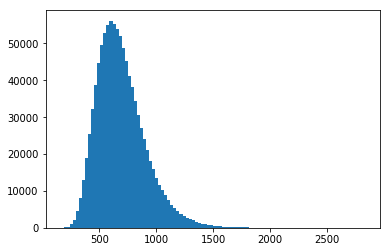

In [3]:
# calibration: unit for money is hundred per year, 2018 Chinese data is collected, suppose wage dist is log normal

interest_rate=0.0435  #the 1-year interest rate in 2018 is 4.35%
beta=1/(1+interest_rate)
c=int(107.31)  # rural disposable income is 10731 in 2018,assuming total income is 10731
urban_disposable_income=int(679.90)  #in 2018, in BJ, urban disposable income is 67990
w_min,w_max=int(254.40),2000  #in 2018, minimun wage in BJ was 2120 per month so w_min is 254.4 (21.2*12) but minimun wage is not disposable income
w_num=w_max-w_min+1  

tol=10e-4
w_vec=np.linspace(w_min,w_max,w_num)
ctr=0

#obtain the empirical log normal distribution
dist_mean,dist_num=np.round(np.log(urban_disposable_income),1),1000000
dist_std=np.round((dist_mean-np.log(w_min))/3,1) # suppose the lower bound is w_min, based on 3 sigma rule, need further investigation

#obtain the empirical log normal distribution
dist=np.random.lognormal(dist_mean,dist_std,dist_num)

print(np.mean(dist))

plt.hist(dist,bins=100)
plt.show()

the sum of pdf is 1.00


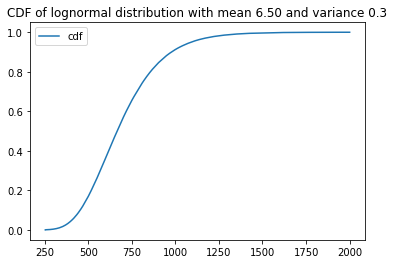

In [4]:
w_pdf=np.zeros(w_num)

w_pdf[0]=np.sum(w_vec[0]>=dist)  #lognormal 是正无穷的，然而wage有下限，因此把下限的pdf设为小于下限的概率之和
for ii in range(1,w_num-1):
    w_pdf[ii]=np.sum(np.logical_and(w_vec[ii-1]<dist,dist<=w_vec[ii]))
    
w_pdf[-1]=np.sum(w_vec[-2]<dist)  #lognormal 是正无穷的，然而wage有上限，因此把上限的pdf设为 大于上限的概率之和

w_pdf=w_pdf/dist_num
print('the sum of pdf is %.2f'%np.sum(w_pdf))  #to check whether pdf sum up to one

w_cdf=[sum(w_pdf[:ii]) for ii in range(w_num)]

#plt.plot(w_vec,w_pdf,label='pdf')
plt.plot(w_vec,w_cdf,label='cdf')
plt.title('CDF of lognormal distribution with mean %.2f and variance %.1f'%(dist_mean,dist_std))
plt.legend()
plt.show()

In [16]:
T=6  #T=0，2，4，6
tuition=300*T  #assuming tuition per year is 30 thousand

time_start=time.time()

v_new=np.zeros(w_num)
v_old=np.ones(w_num)

while np.max(np.abs(v_new-v_old))>tol:
    v_old=np.copy(v_new)
    v_expected=np.sum(v_old*w_pdf)
    for w_i in range(w_num):
        #v_new[w_i]=max((1-beta**T)*c/(1-beta)+w_vec[w_i]*beta**T/(1-beta)-tuition,c+beta*v_expected)
        v_new[w_i]=max(w_vec[w_i]*beta**T/(1-beta)-tuition,c+beta*v_expected)
        #v_new[w_i]=max((1-beta**T)*c/(1-beta)+(beta**T)*(1-beta**(year-T))*w_vec[w_i]/(1-beta)-tuition,c+beta*v_expected*((year-1)/year))
        #v_new[w_i]=max((beta**T)*(1-beta**(year-T))*w_vec[w_i]/(1-beta)-tuition,c+beta*v_expected*((year-1)/year))
    ctr+=1

time_end=time.time()
time_during=time_end-time_start

index=sum(v_new<=v_new[0])
accept_rate=sum(dist>=w_vec[index])/dist_num
print('the reservation wage is %.3f '%(w_vec[index]*100))
print('the prob of acceptance is %.4f'%accept_rate)

the reservation wage is 88500.000 
the prob of acceptance is 0.1702


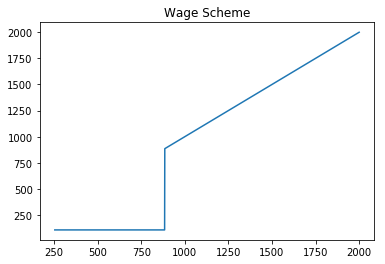

Expected Income is 26830.384


In [17]:
# compute expected income
wage_scheme=np.copy(w_vec)
wage_scheme[:index]=c
plt.plot(w_vec,wage_scheme)
plt.title('Wage Scheme')
plt.show()
print('Expected Income is %.3f'%(sum(wage_scheme*w_pdf)*100))

In [18]:
# compute income coefficient
# step 1: compute the income and weight(sum up to 1)
income=np.zeros(w_num-index+2)
income[0]=0 # labor with income of 0 is added for the sake of compputing Gini otherwise first elements would be ignored
income[1]=c
income[2:]=w_vec[index:]

weight=np.zeros(w_num-index+2)
weight[0]=0
weight[1]=sum(w_pdf[:index])
weight[2:]=w_pdf[index:]

# step 2: sort by income, ascending
# step 3: compute the accumulative weight sum 
weight_cumsum=weight.cumsum()
# step 4: compute the accumulative income sum 
income_sum_array=income*weight
income_cumsum=income_sum_array.cumsum()
income_cumsum=income_cumsum/sum(income_sum_array)
# step 5: calculate the Gini coefficients
weight_diff=weight_cumsum[1:]-weight_cumsum[0:-1]
gini_diff=weight_cumsum-income_cumsum
Gini_income=sum(gini_diff[1:]*weight_diff)
print('The Gini coefficient for income is %.5f'%(2*Gini_income))

The Gini coefficient for income is 0.91973
